# Description

This notebook is a tutorial on how to use Tensorflow for time series data.

In [1]:
# Install required libs on the fly.
# Tensorflow needs to be downloaded from pip as poetry relies on the package metadata to resolve packages, 
# tensorflow does not consistently contain the required metadata. https://github.com/python-poetry/poetry/issues/8764
!sudo /bin/bash -c "(source /venv/bin/activate; pip install tensorflow)"
!sudo /bin/bash -c "(source /venv/bin/activate; pip install tensorflow-probability)"
!sudo /bin/bash -c "(source /venv/bin/activate; pip install tf-keras)"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import logging
import collections
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.plotting as pdp
import seaborn as sns
import scipy.stats as stats
import sklearn.metrics as metrics
import tensorflow as tf
import tf_keras
import tensorflow_probability as tfp


import helpers.hprint as hprint
import helpers.hdbg as hdbg
import helpers.hpandas as hpanda

2025-01-20 05:38:12.924564: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-20 05:38:13.078549: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-20 05:38:13.281759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737351493.499672     470 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737351493.562813     470 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 05:38:13.989490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-8ef47a07-a430-40a1-bdaf-daa3a3c769c9.json'


# Config

In [7]:
config = {
    # Train/test split.
    "train_start_date": "2020-01-01",
    "train_end_date": "2023-12-31",
    "test_start_date": "2024-01-01",
    "test_end_date": "2024-12-31",
    "data": {
        # Linear trend params.
        "slope": 0.005,
        "intercept": 15,
        # Fourier term params for seasonality component.
        "weekly_amp_sin": 5.0,
        "weekly_amp_cos": 2.5,
        # List of holidays and their impact.
        "holidays_dates": ['2020-12-25', '2021-12-25', '2022-12-25', "2023-12-25", "2024-12-25"],
        "holidays_impact" : 0.25,
        # Autoregression params.
        "ar_order": 1,
        "phi": 0.7,
        # Noise std.
        "seed": 42,
        "noise_sigma": 2.0,
    },
    "model": {
       "learning_rate": 0.1,
        "num_steps": 200,
    },
}
print(config)

{'train_start_date': '2020-01-01', 'train_end_date': '2023-12-31', 'test_start_date': '2024-01-01', 'test_end_date': '2024-12-31', 'data': {'slope': 0.005, 'intercept': 15, 'weekly_amp_sin': 5.0, 'weekly_amp_cos': 2.5, 'holidays_dates': ['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25'], 'holidays_impact': 0.25, 'ar_order': 1, 'phi': 0.7, 'seed': 42, 'noise_sigma': 2.0}, 'model': {'learning_rate': 0.1, 'num_steps': 200}}


# Generate data

In [8]:
# Generate date range.
dates = pd.date_range(start=config["train_start_date"], end=config["test_end_date"], freq='D')
time = np.arange(len(dates))
# Define linear trend.
y_trend = config["data"]["slope"] * time + config["data"]["intercept"]
# Define the seasonality factor.
p_weekly = 7
y_weekly_seasonality = config["data"]["weekly_amp_sin"] * np.sin(2 * np.pi * time / p_weekly) + config["data"]["weekly_amp_cos"] * np.cos(2 * np.pi * time / p_weekly)
# Define holidays impact.
holiday_effect = np.zeros(len(dates))
holiday_effect[np.isin(dates.date, pd.to_datetime(config["data"]["holidays_dates"]).date)] = config["data"]["holidays_impact"]
# Define white noise.
np.random.seed(config["data"]["seed"])
noise = np.random.normal(loc=0, scale=config["data"]["noise_sigma"], size=len(time))
# Add autoregressive behavior.
y = np.zeros(len(time))
y[0] = y_trend[0] + y_weekly_seasonality[0] + holiday_effect[0] + noise[0]
for i in range(1, len(time)):
    y[i] = config["data"]["phi"] * y[i-1] + y_trend[i] + y_weekly_seasonality[i] + holiday_effect[i] + noise[i]
df = pd.DataFrame({"ds": dates, "y": y})
# Add lagged value of the target as a feature.
df["y.lag1"] = df["y"].shift(1)
# The first row is NaN -> drop it.
df = df.dropna()
_LOG.info(hpanda.df_to_str(df, log_level=logging.INFO))

,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1824,2024-12-29 00:00:00,77.847267,82.588283
1825,2024-12-30 00:00:00,74.071026,77.847267
1826,2024-12-31 00:00:00,71.448487,74.071026


INFO  None


<Axes: title={'center': 'Original data'}, xlabel='Time', ylabel='Target variable'>

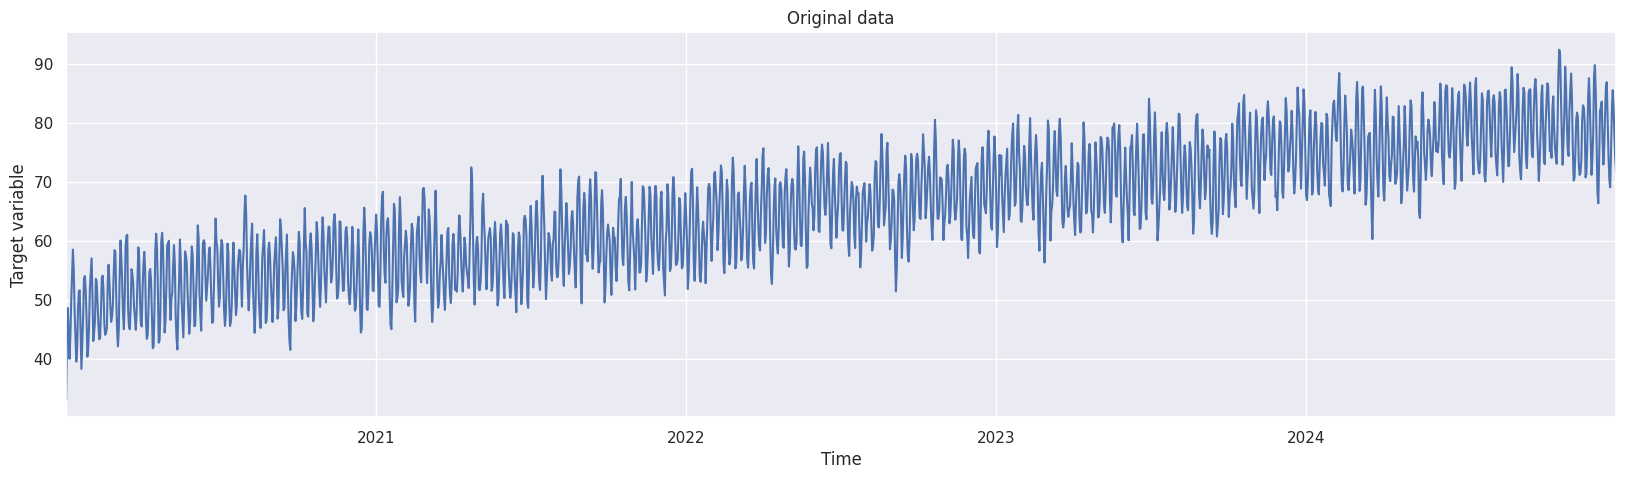

In [9]:
df.set_index("ds")["y"].plot(title="Original data", ylabel="Target variable", xlabel="Time")

## Plotting Helpers

In [10]:
# It is used to register date converters with Matplotlib. 
# This ensures that Matplotlib can properly handle and plot date-related data.
pdp.register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [11]:
def plot_forecast(
    x: np.ndarray,
    y: np.ndarray,
    forecast_mean: np.ndarray,
    forecast_scale: np.ndarray,
    forecast_samples: np.ndarray,
    title: str,
    x_locator: Optional[plt.Locator] = None,
    x_formatter: Optional[plt.Formatter] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a forecast distribution against the 'true' time series.

    :param x: The time points for the entire dataset.
    :param y: The ground truth values for the time series.
    :param forecast_mean: The mean values of the forecasted distribution.
    :param forecast_scale: The scale (standard deviation) of the forecasted distribution.
    :param forecast_samples: Samples drawn from the forecasted distribution.
    :param title: The title of the plot.
    :param x_locator: Optional locator for the x-axis (e.g., for dates).
    :param x_formatter: Optional formatter for the x-axis labels.
    :return: A tuple containing the figure and axes objects of the plot.
    """
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    #
    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    #
    ax.plot(x, y, lw=2, color=c1, label="ground truth")
    forecast_steps = x[num_steps_train : num_steps_train + num_steps_forecast]
    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)
    ax.plot(
        forecast_steps,
        forecast_mean,
        lw=2,
        ls="--",
        color=c2,
        label="forecast",
    )
    ax.fill_between(
        # x-axis values (e.g., time steps or forecast points)
        forecast_steps,
        # Lower boundary of the confidence interval
        forecast_mean - 2 * forecast_scale,
        # Upper boundary of the confidence interval
        forecast_mean + 2 * forecast_scale, 
        color=c2,
        alpha=0.2,
    )
    ymin, ymax = (
        min(np.min(forecast_samples), np.min(y)),
        max(np.max(forecast_samples), np.max(y)),
    )
    yrange = ymax - ymin
    ax.set_ylim([ymin - yrange * 0.1, ymax + yrange * 0.1])
    ax.set_title("{}".format(title))
    ax.legend()
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    return fig, ax



In [12]:
def plot_components(
    dates: np.ndarray,
    component_means_dict: Dict[str, np.ndarray],
    component_stddevs_dict: Dict[str, np.ndarray],
    *,
    x_locator: Optional[plt.Locator] = None,
    x_formatter: Optional[plt.Formatter] = None,
) -> Tuple[plt.Figure, Dict[str, plt.Axes]]:
    """
    Plot the contributions of posterior components in a single figure.

    :param dates: Array of dates corresponding to the time series.
    :param component_means_dict: Dictionary where keys are component names 
        and values are arrays of mean contributions of each component.
    :param component_stddevs_dict: Dictionary where keys are component names 
        and values are arrays of standard deviations of each component.
    :param x_locator: Optional locator for the x-axis (e.g., for dates).
    :param x_formatter: Optional formatter for the x-axis labels.
    :return: A tuple containing the figure and an ordered dictionary of axes objects, 
        keyed by component names.
    """
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    #
    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    #
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(
            dates,
            component_mean - 2 * component_stddev,
            component_mean + 2 * component_stddev,
            color=c2,
            alpha=0.5,
        )
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    #
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict



In [13]:
def plot_one_step_predictive(
    dates: np.ndarray,
    observed_time_series: np.ndarray,
    one_step_mean: np.ndarray,
    one_step_scale: np.ndarray,
    *,
    x_locator: Optional[plt.Locator] = None,
    x_formatter: Optional[plt.Formatter] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a time series against a model's one-step predictions.

    :param dates: Array of dates corresponding to the time series.
    :param observed_time_series: Array of observed values in the time series.
    :param one_step_mean: Array of one-step-ahead predicted mean values.
    :param one_step_scale: Array of one-step-ahead predicted scale (standard deviation).
    :param x_locator: Optional locator for the x-axis (e.g., for dates).
    :param x_formatter: Optional formatter for the x-axis labels.
    :return: A tuple containing the figure and axes objects of the plot.
    """
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    #
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(
        dates,
        one_step_mean - one_step_scale,
        one_step_mean + one_step_scale,
        alpha=0.1,
        color=c2,
    )
    ax.legend()
    #
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax



## Tran and Test Split

In [14]:
start_date_filter = df["ds"] >= config["train_start_date"]
end_date_filter = df["ds"] <= config["train_end_date"]
df_train = df[start_date_filter & end_date_filter]
_LOG.info(hpanda.df_to_str(df_train, log_level=logging.INFO))



,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1458,2023-12-29 00:00:00,85.64892,80.658681
1459,2023-12-30 00:00:00,83.512603,85.64892
1460,2023-12-31 00:00:00,76.060069,83.512603


INFO  None


In [15]:
start_date_filter = df["ds"] >= config["test_start_date"]
end_date_filter = df["ds"] <= config["test_end_date"]
df_test = df[start_date_filter & end_date_filter].reset_index(drop=True)
_LOG.info(hpanda.df_to_str(df_test, log_level=logging.INFO))

,ds,y,y.lag1
0,2024-01-01 00:00:00,67.66751,76.060069
1,2024-01-02 00:00:00,66.908778,67.66751
2,2024-01-03 00:00:00,69.950103,66.908778
,...,...,...
363,2024-12-29 00:00:00,77.847267,82.588283
364,2024-12-30 00:00:00,74.071026,77.847267
365,2024-12-31 00:00:00,71.448487,74.071026


INFO  None


## Model and Fitting

In [16]:
def build_model(observed_time_series: np.ndarray, holiday_features: np.ndarray) -> tfp.sts.Sum:
    """
    Build a Structural Time Series (STS) model for forecasting.

    The model includes the following components:
    - A local linear trend to capture long-term changes.
    - A seasonal component to account for day-of-week effects.
    - An autoregressive component to model temporal dependencies.

    :param observed_time_series: The observed time series data as a NumPy array.
    :return: An STS model combining trend, seasonal, and autoregressive components.
    """
    trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)
    day_of_week_effect = tfp.sts.Seasonal(
        num_seasons=7,
        num_steps_per_season=1,
        observed_time_series=observed_time_series,
        name="day_of_week_effect",
    )
    autoregressive = tfp.sts.Autoregressive(
        order=1,
        observed_time_series=observed_time_series,
        name="autoregressive",
    )
    # Using example of holiday indicators https://www.tensorflow.org/probability/api_docs/python/tfp/sts/LinearRegression
    holiday_effect = tfp.sts.LinearRegression(
         design_matrix=holiday_features,
         name='holiday_effect'
    )
    
    # Combine components into a single model
    model = tfp.sts.Sum(
        [trend, day_of_week_effect, autoregressive],
        observed_time_series=observed_time_series,
    )
    return model
     


In [17]:
# Generate a date range for the entire period
all_dates = pd.date_range(start=config["train_start_date"], end=config["train_end_date"])
# Extract holiday dates from the configuration
holiday_dates = pd.to_datetime(config["data"]["holidays_dates"])
holiday_features = np.isin(all_dates, holiday_dates).astype(float)
holiday_indicators = np.zeros((len(all_dates), len(holiday_dates)))
for i, holiday in enumerate(holiday_dates):
    holiday_indicators[:, i] = (all_dates == holiday).astype(int)
_LOG.info("holdiay features = %s, shape = %s", holiday_indicators, holiday_indicators.shape)

INFO  holdiay features = [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape = (1461, 5)


In [18]:
model = build_model(df_train["y"].to_numpy(), holiday_indicators)

2025-01-20 05:43:13.483022: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Background

This code is part of a **Variational Inference** (VI) process used to approximate the posterior distribution of a Bayesian model. In this case, TensorFlow Probability (TFP) is used to build a **surrogate posterior** and optimize it to approximate the true posterior distribution of a model. The idea behind variational inference is to turn the problem of calculating intractable posteriors into a tractable optimization problem. This is done by approximating the true posterior with a simpler distribution (the surrogate posterior) and then optimizing it to be as close as possible to the true posterior.

#### Key Concepts and When to Use

- **Bayesian Inference**: In Bayesian inference, we aim to calculate the posterior distribution of the model parameters given the data. This can be computationally expensive or intractable for complex models.
- **Variational Inference (VI)**: VI is a method to approximate the posterior distribution by optimizing a surrogate distribution (which is easier to compute). It does this by minimizing the **Evidence Lower Bound (ELBO)**, which is a measure of how close the surrogate posterior is to the true posterior.
  
**Optimizing the Variational Loss Function (ELBO):**

```python
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_distribution(
        observed_time_series=df_train["y"].to_numpy()).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf_keras.optimizers.Adam(learning_rate=config["model"]["learning_rate"]),
    num_steps=num_variational_steps,
    jit_compile=True)
```

- **Purpose**: This performs the optimization of the variational posterior by minimizing the **ELBO loss**.
- **How it works**: 
  - `target_log_prob_fn`: This is the log-probability of the model’s joint distribution, evaluated on the observed data.
  - `surrogate_posterior`: This is the surrogate posterior distribution (`qs`), which we aim to optimize.
  - `optimizer`: The optimizer used to minimize the ELBO loss. Here, Adam is used with a learning rate specified in the config.
  - `num_steps`: The number of optimization steps, controlled by `num_variational_steps`.
  - `jit_compile`: This enables JIT (Just-In-Time) compilation to speed up the optimization process using TensorFlow's XLA (Accelerated Linear Algebra).
- **When to use**: This is the core part of variational inference, used when we want to approximate the posterior distribution in a computationally efficient way. It’s helpful for models where traditional sampling-based approaches (e.g., MCMC) are too slow or impractical.

### Model Parameters

The model consists of various components, and the parameters pertain to these components. Let’s go over some typical model parameters in a **Structural Time Series** (STS) model and their role:

1. **Trend Parameters**:
   - These represent the long-term movements in the time series.
   - Common parameters:
     - **Level**: The current level of the time series.
     - **Slope**: The rate of change of the level over time.

2. **Seasonal Components**:
   - These capture periodic patterns, such as weekly or yearly cycles.
   - Common parameters:
     - **Amplitude**: The strength of the seasonal effect.
     - **Period**: The length of the season (e.g., 7 for weekly seasonality).
   
3. **Autoregressive Parameters**:
   - These capture dependencies between time steps.
   - Common parameters:
     - **Order**: The number of past time steps considered in the autoregressive process (e.g., AR(1) for one-step lag).
     - **Coefficient**: The weight of the past time step in predicting the current value.

4. **Noise Parameters**:
   - These represent the random fluctuations or errors in the data.
   - Common parameters:
     - **Observation Noise Scale**: The variance of the observation noise.
   

In [19]:
# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)

I0000 00:00:1737351817.692478     470 service.cc:148] XLA service 0x25fc3630 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737351817.692518     470 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-01-20 05:43:38.024978: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/split_seed/sanitize_seed/seed
2025-01-20 05:43:38.080470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737351828.468748     470 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


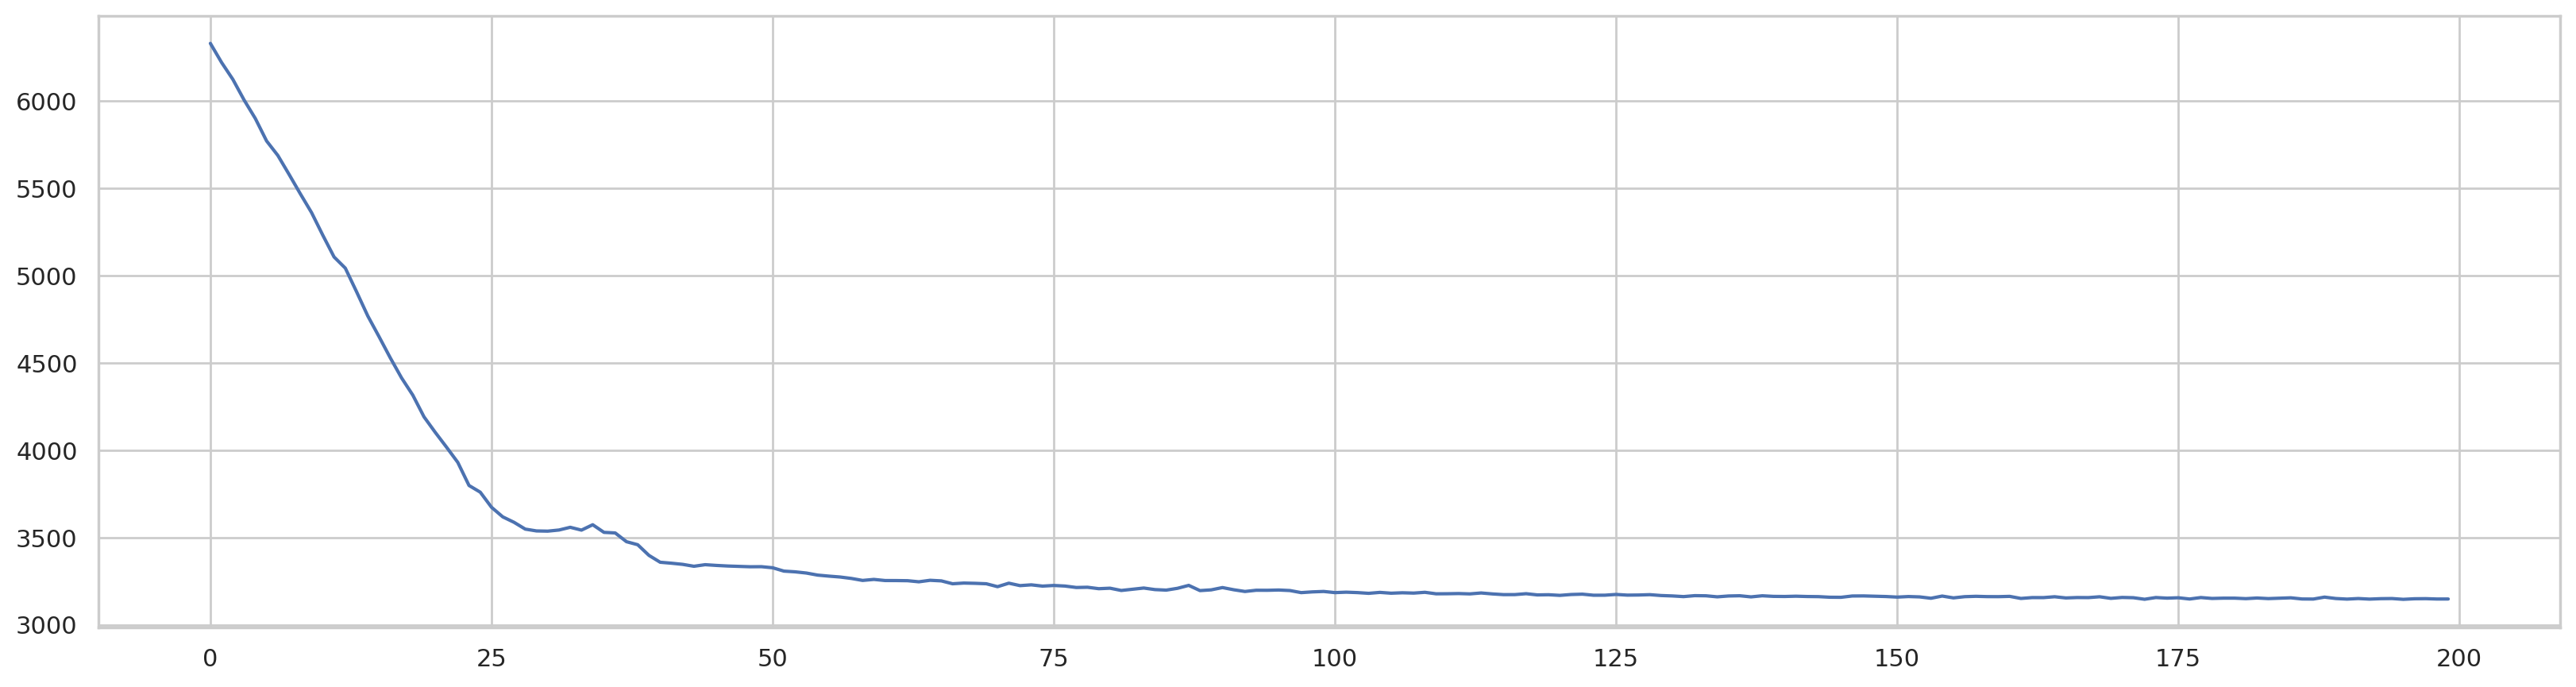

In [20]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = config["model"]["num_steps"]

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_distribution(
        observed_time_series=df_train["y"].to_numpy()).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf_keras.optimizers.Adam(learning_rate=config["model"]["learning_rate"]),
    num_steps=num_variational_steps,
    jit_compile=True)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_ = variational_posteriors.sample(50)

### Explanation of Parameters and Outputs:

#### 1. **`LocalLinearTrend/_level_scale` and `LocalLinearTrend/_slope_scale`**
   - **Definition**: These represent the variability (or uncertainty) in the level and slope of the local linear trend in the time series. 
     - **Level scale** (`_level_scale`): Refers to the variability or noise in the level of the trend component in the Local Linear Trend model. 
     - **Slope scale** (`_slope_scale`): Reflects variability in the rate of change (or slope) of the trend.
#### 2. **`day_of_week_effect/_drift_scale`**
   - **Definition**: Represents the variability in the day-of-week effects (e.g., systematic variations in the time series that recur weekly). 
   - **Seasonality Model**: Unlike Prophet, which models seasonality using Fourier terms (sine and cosine functions), this implementation likely uses a simpler drift-based approach. 
     
#### 3. **`autoregressive/_level_scale`**
   - **Definition**: Represents the noise scale or variability at the level of the autoregressive (AR) process. 
   - **Autoregressive Model**: This parameter reflects how much the AR process deviates from the expected trajectory defined by its coefficients.
     - Higher values of `_level_scale` indicate a noisier AR process, whereas lower values suggest that the process closely follows the AR coefficients.


In [21]:
_LOG.info("Inferred parameters:")
for param in model.parameters:
  _LOG.info("%s: %s +- %s", param.name,
                              np.mean(q_samples_[param.name], axis=0),
                              np.std(q_samples_[param.name], axis=0))

INFO  Inferred parameters:
INFO  observation_noise_scale: 0.2946217241664946 +- 0.09571672715486111
INFO  LocalLinearTrend/_level_scale: 0.08844052573972819 +- 0.04085550375343446
INFO  LocalLinearTrend/_slope_scale: 0.003066085696300991 +- 0.0010269508523181002
INFO  day_of_week_effect/_drift_scale: 0.04941331041249066 +- 0.009592350816657496
INFO  autoregressive/_coefficients: [0.72043929] +- [0.02150897]
INFO  autoregressive/_level_scale: 1.9706321369120285 +- 0.03577339549530959


In [22]:
_LOG.info("True Trend slope = %s, Predicted Trend slope =%s", config["data"]["slope"], np.mean(q_samples_["LocalLinearTrend/_slope_scale"]))

INFO  True Trend slope = 0.005, Predicted Trend slope =0.003066085696300991


In [24]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = tfp.sts.decompose_by_component(
    model,
    observed_time_series=df_train["y"].to_numpy(),
    parameter_samples=q_samples_)

In [25]:
component_means_, component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

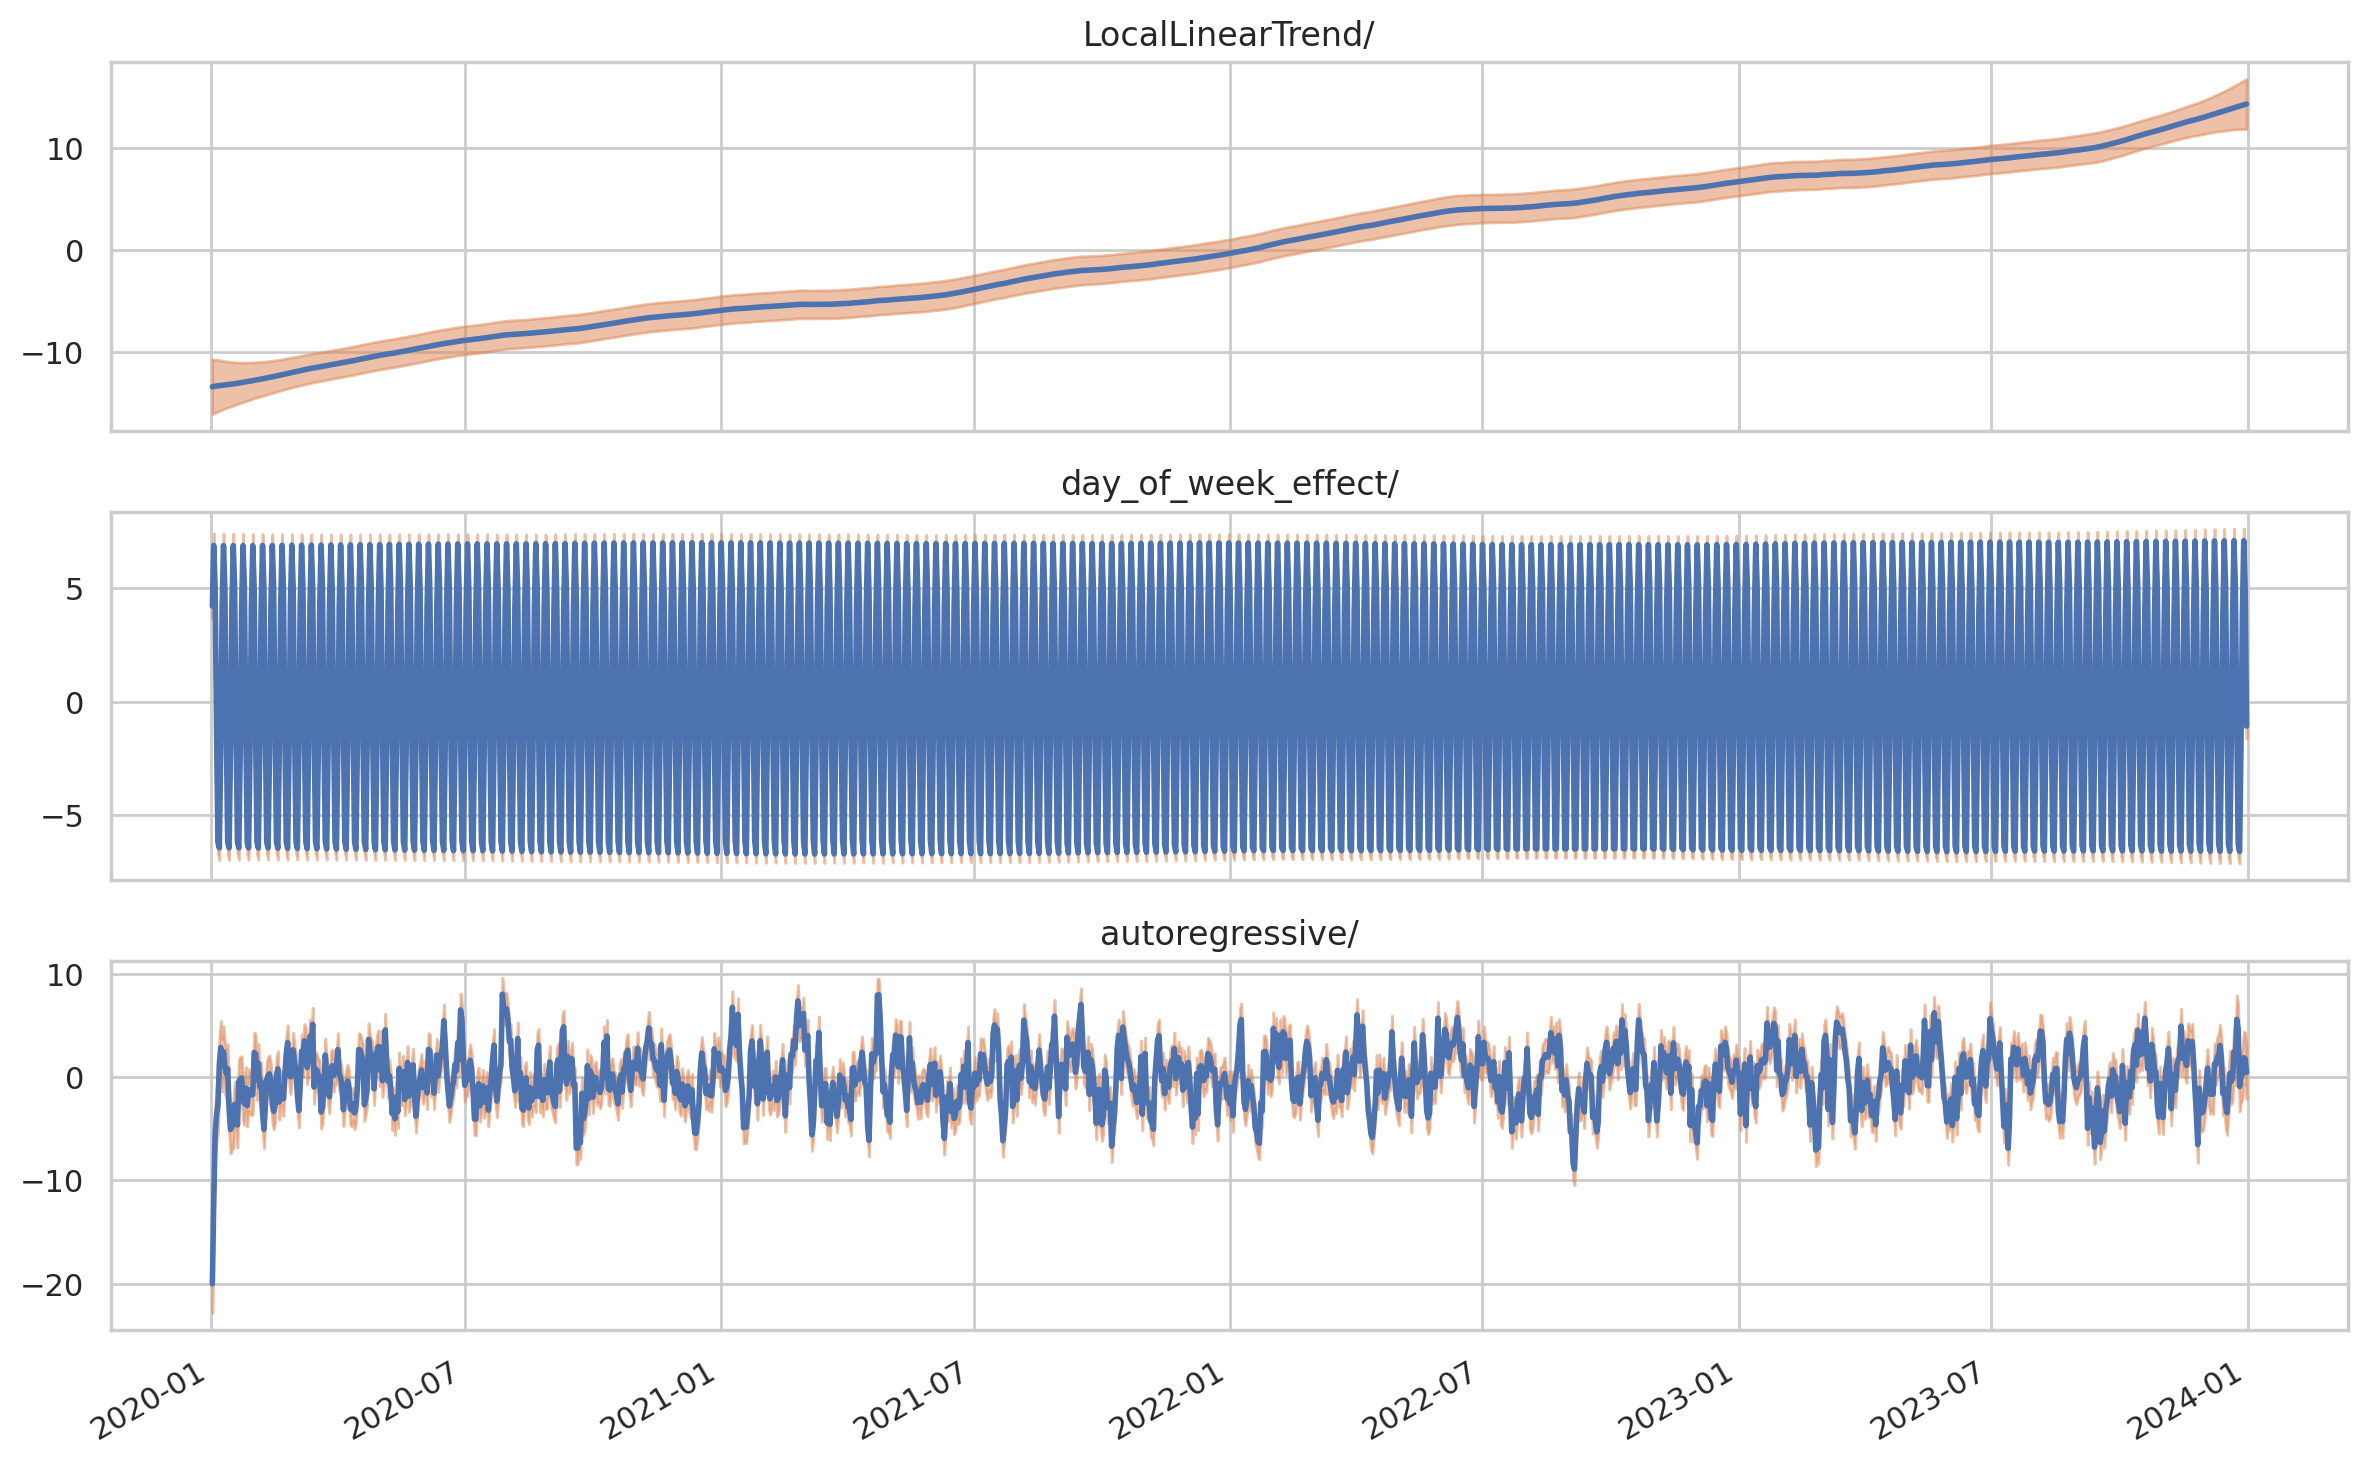

In [26]:
_ = plot_components(df_train["ds"], component_means_, component_stddevs_,
                    x_locator=None, x_formatter=None)

In [32]:
# Forecast the prediction.
forecast_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=df_train["y"].to_numpy(),
    parameter_samples=q_samples_,
    num_steps_forecast=len(df_test))

In [33]:
num_samples=10
(
    forecast_mean,
    forecast_scale,
    forecast_samples
) = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0],
    forecast_dist.sample(num_samples).numpy()[..., 0]
    )

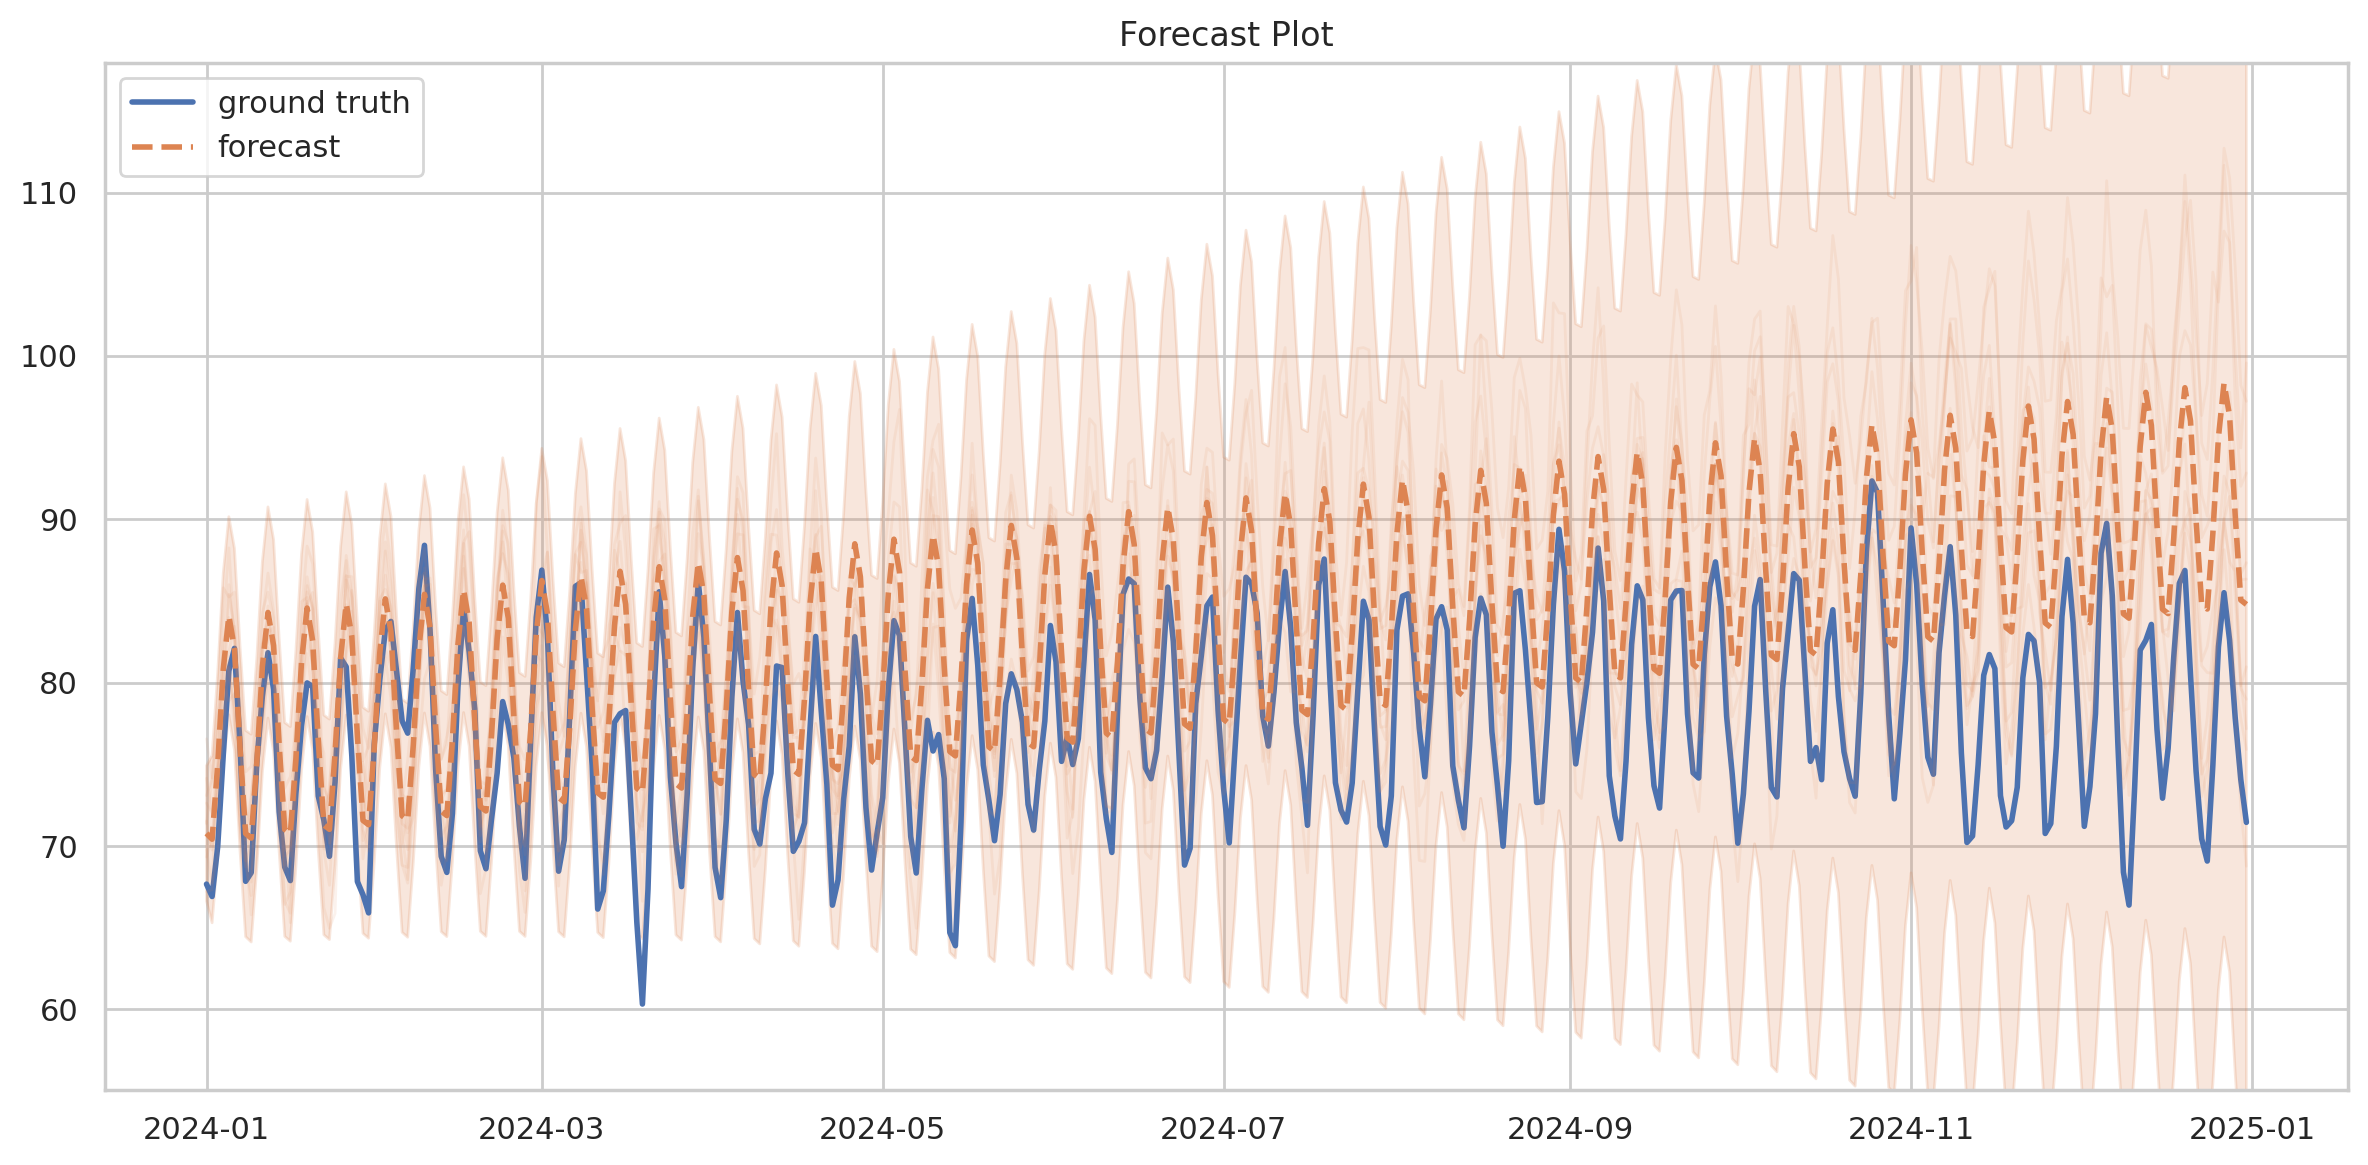

In [34]:
fig, ax = plot_forecast(df_test["ds"], df_test["y"].to_numpy(),
                        forecast_mean,
                        forecast_scale,
                        forecast_samples,
                        title="Forecast Plot",
                        x_locator=None, x_formatter=None)
fig.tight_layout()

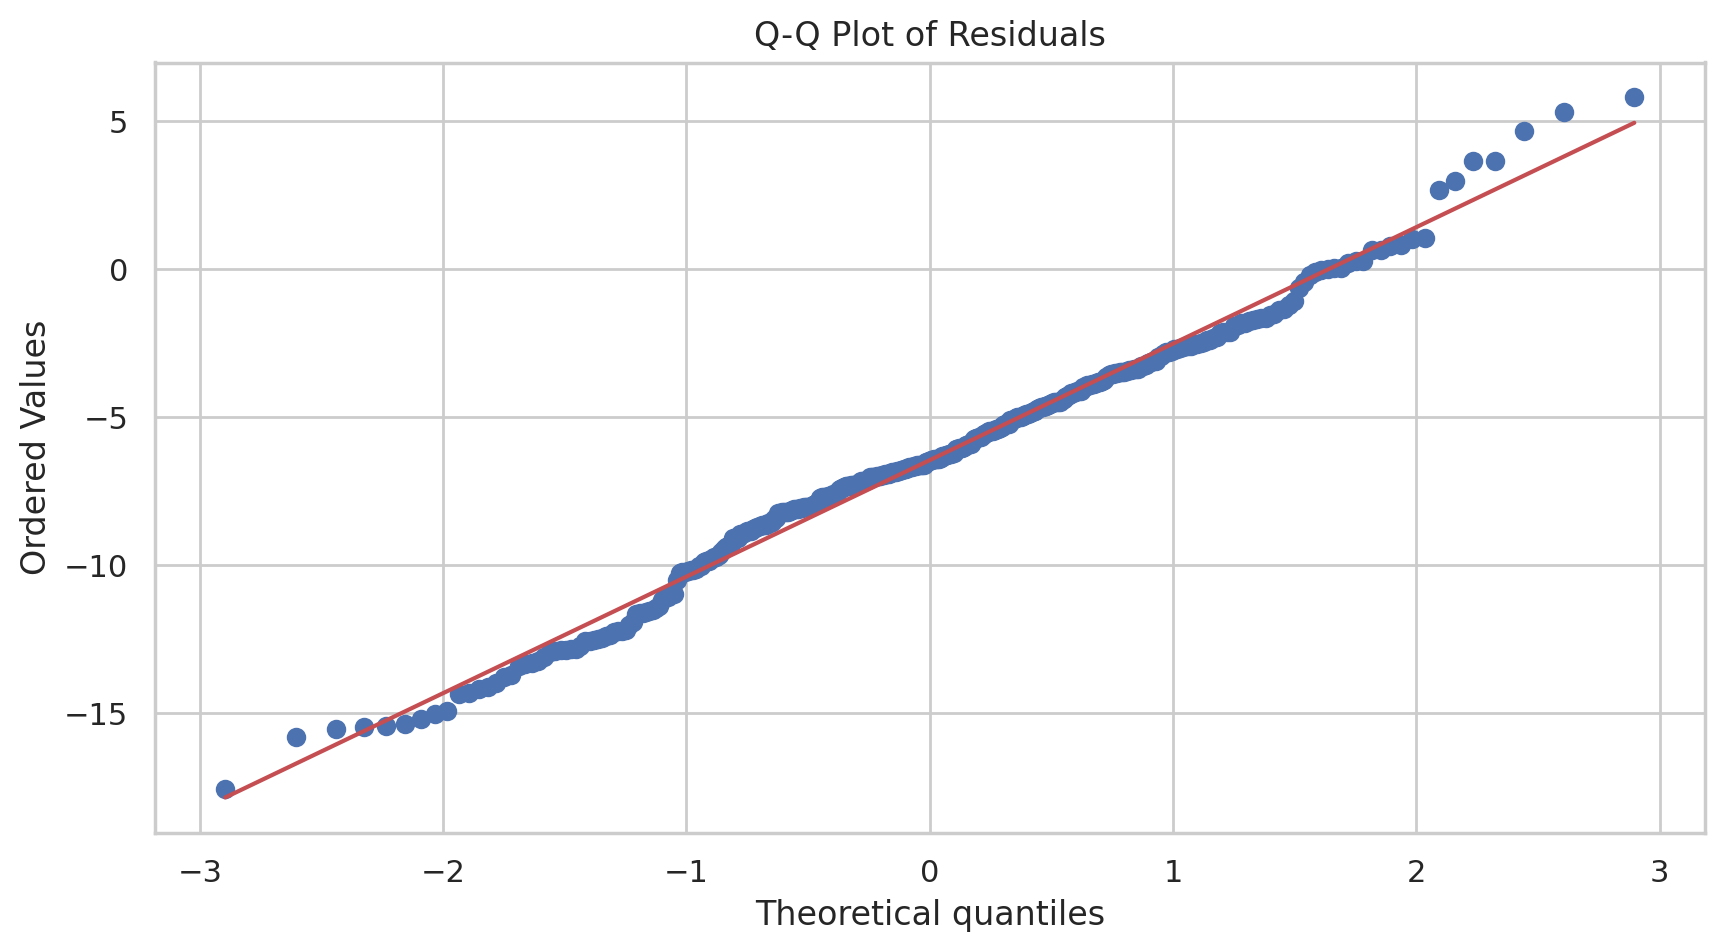

In [35]:
# Calculate residuals
residuals = df_test["y"].to_numpy() - forecast_mean

# Q-Q Plot for Residuals
plt.figure(figsize=(10, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

## Performance Metric

In [36]:
mae = metrics.mean_absolute_error(df_test["y"].to_numpy(), forecast_mean)
_LOG.info("Mean Absolute Error (MAE): %s", mae)
mse = metrics.mean_squared_error(df_test["y"].to_numpy(), forecast_mean)
_LOG.info("Mean Squared Error (MSE): %s", mse)

INFO  Mean Absolute Error (MAE): 6.6413526940719025
INFO  Mean Squared Error (MSE): 57.068575951514525
